Decision Trees
Widely used models for classification and regression tasks. They are a heirarchy of if/else questions. 

To build a tree, the algorithm searchs over all possible tests and finds the one that is most informative abou tthe target variable. Splitting the dataset horizontally at x[1]=.0596 yield the most information; it best separates the points in class 0 from teh points in class 1. The top node, also called the root, represents the whole dataset. In the given data, the split is done by testing whether ex[1] <= .0596, indicated by the black line. If the test is true, a point is assigned to the left node, which contains 2 points belongigng ot class 0 and32 points belonging to class 1. Otherwise the point is assigned to the right node, whihc contains 48 points belonging to class 0 and 18 points belonging to class 1. We're gonna see some inaccuracies, but we an build a more accurate model by repeating the process of looking for the best test in both regions.

The recursive partitioning of the data is repeated until each region in the partition only contains a single target value (a single class or a single regression value). A leaf of the tree that contains data points that all share the same target value is called pure. 

A prediction on the new point is made by checking which region of the partition of the feature space the point lies in, and then predicting the majorit target (or the single target in the case of pure leaves) in that region.

Controlling complexity of decision trees
There are two common strategies to prevent overfitting: stopping the creation of the tree early (also called pre-pruning), or building the tree but then removing or collapsing nodesthat contain little information (also called post-pruning or just pruning). Possible criteria for pre-pruning include limiting the max depth of the tree, limiting the max number of leaves, or requiring a min number of points in a node to keep splitting. 

In [3]:
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train,y_train)
print('Accuracy on trianing set {:.3f}'.format(tree.score(X_train,y_train)))
print('Accuracy on teste set: {:.3f}'.format(tree.score(X_test, y_test)))

Accuracy on trianing set 1.000
Accuracy on teste set: 0.937


If we don't restrict the depth of a decision tree, the tree can become arbitrarily deeep and complex. Unpruned trees are therefore prone to overfitting and not generalizing well to new data. Now let's apply pre-pruning to the tree, which will stop developing the tree before we perfectly fit to the training data. One option is to stop building the tree after a certain depth has been reached. Here we set max_depth=4, meaning only four consecuritve questions can be asked. Limiting the depth of the tree decreases overfitting. This leads to lower accuracy on the training set, but improvements on the test set:

In [4]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print('Accuracy on the training set: {:.3f}'.format(tree.score(X_train,y_train)))
print('Accuracy on teste set: {:.3f}'.format(tree.score(X_test, y_test)))


Accuracy on the training set: 0.988
Accuracy on teste set: 0.951


Analyzing Decision Trees
We can visualize the tree using the export_graphviz function from the tree module. This writes a file in teh .dot format, which is  atext file format for storing graphs. We set an option to color the nodes to reflect the majority class in each node and pass the class and features names so the tree can be properly labeled.

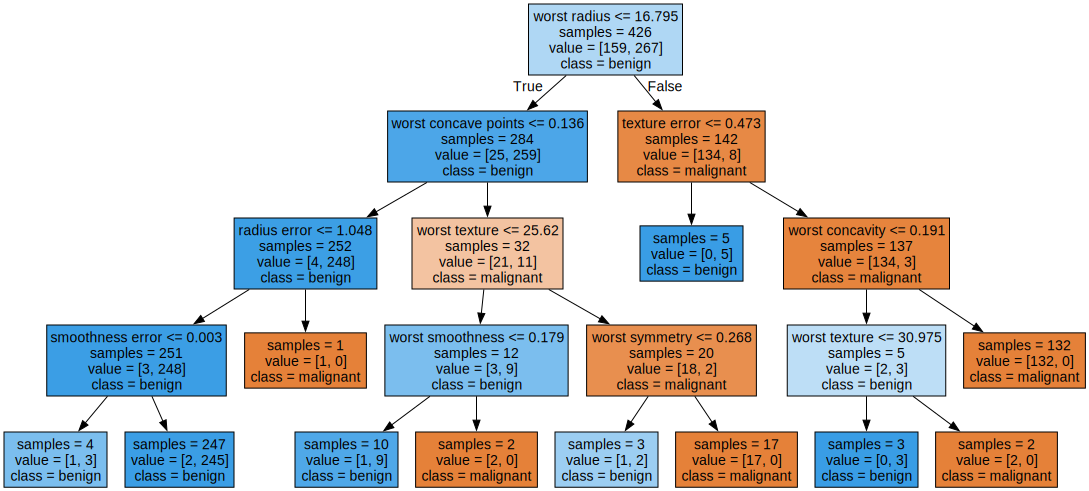

In [5]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', class_names=['malignant', 'benign'], feature_names=cancer.feature_names, impurity=False, filled = True)

import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Ensembles of Decision Trees
Ensembles are methods that combine multiple machine learning models to create more powerful models. There are many models in the machine learning literature that belong to this category, but there are two ensemble models that have proven to be effective on a wide range of datasets for classification and regression, both of which use decision trees as their building blocks: random forests and gradient boosted decision trees.

Random Forests
A main drawback of decision trees is that they tend to overfit the training data. Random forests are one way to address this problem. A random forest is essentially a collection of deciion trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce teh amount of overfitting by averaging their results.


Building Random Forests
To build a random forest model, you need to decide on the number of trees to build (the n_estimators parametere of RandomForestRegressor or RandomForestClassifier). For example, we want to build 10 trees. These trees will be built completely independently from each other, and the algorithm will make different random choices for each tree to make sure the trees are distinct. To build a tree, we first take what is called a bootstrap sample of our data. That is, from our n_samples data points, we repeatedly draw an example randomly with replacement, n_samples times. This will create a dataset that is as big as the  original dataset, but some data points will be missing from it, and some will be repeated.

Next, a decision tree is built based on this newly created dataset. However, the algorithm we described for the decision tree is slightly modified. Instead of looking for the best test for each node, in each node hte algorithm randly selects a subset of the features, and it looks for the best possible test involving one of these features. The number of features that are selected is controled by the max_features parameter. This selection of a subset of features is repeated separately in each node, so that each node in a tree cam make a decision using a different subset of the features.

The boostrap sampling leads to each decision tree in the random forest beuing built on a slightly different dataset. Because of the selection of features in each node, each split in each tree operates on a different subset of features. Together, these two mechanisms ensure that all the trees in the random forest are different.

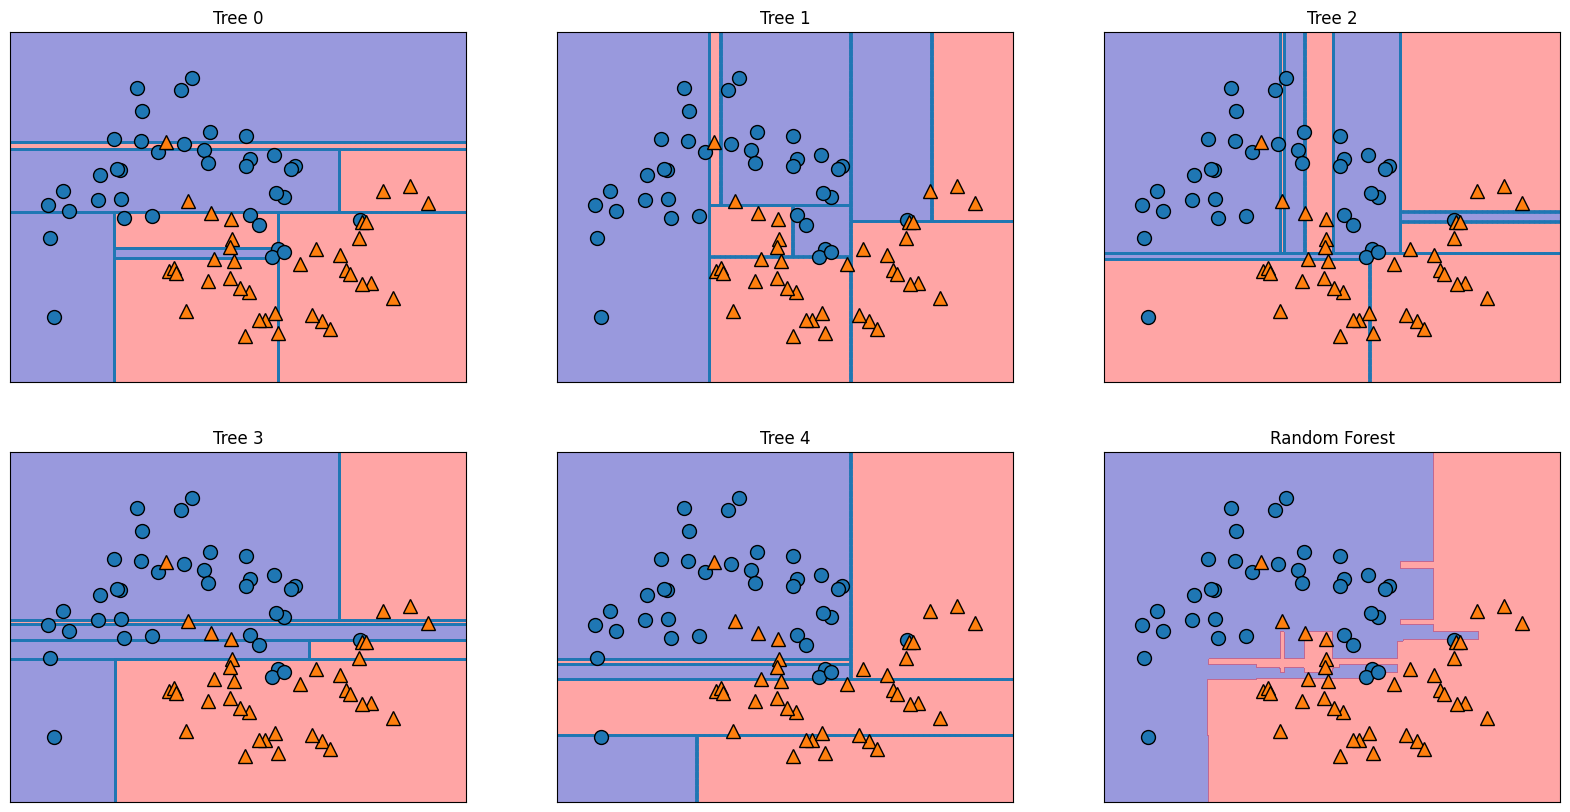

In [8]:
# Analyzing Random Forests

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt


X,y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train,y_train)

# the trees that are built as part of the random forest are stored in the estimator_ attribute
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for i, (ax,tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title('Tree {}'.format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1,-1],alpha=.4)
axes[-1,-1].set_title('Random Forest')
mglearn.discrete_scatter(X_train[:,0], X_train[:,1], y_train)

Random Forest Strengths, Weaknesses, and Parameters
You should keep in mind that random forests, by their nature, are random, and setting different random states (or not setting the random state at all) can drastically change the model that is built. The more trees there are in the forest, the more robust it will be against the choice of random states. If you want to have reproducible results, it is important to fix the random_state.

Random forests don't tend to perform well on very high dimensional, sparse data, such as text data. For this kind of data, linear models might be more appropriate. Random forests usually work well even on very large datasets, and training can easily be parallelized over many CPU cores within a powerful computer. However, random forests require more memory and are slower to train and to predict than linear models. If time and memory are important in an application, it might make sense to use a linear model instead.

The important parameters to adjust are n_estimators, max_features, and possibly pre-pruning options like max_depth. For n_estimators, larger is always better. Averageing more trees will yield a more robust ensemble by reducing overfitting. However, there are diminishing returns, and more trees need more memory and more time to train. A common rule of thumb is to build 'as many as you have time/memory for.'

Gradient Boosted Regression Trees (gradient boosting machines)
The gradient boosted regression tree is anoth ensemble method that combines multiple decision trees to create a more powerful model. Despite the "regression" in the name, these models can be used for regression and classification. In contrast to the random forest approach, gradient boosting works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one. By defeault, there is no randomization in gradient boosted regression trees; instead, strong pre-pruining is used. Gradient boosted trees often use veyr shallow trees, of depth one to five, which makes the model smaller in terms of memory and makes predictions faster.

Apart from pre-pruning the number of trees in the ensemble, another important parameter of gradient boosting is the learning_rate, which controls how strongly each tree tries to correct the mistakes of the previous trees. A higher learning rate means each tree can make stronger corrections, allowing fo rmore complex models. Adding more trees to the ensemble, which can be accomplished by increasing n_estimators, also increases the model complexity, as the model has more chances to correct mistakes on the training set.

In [ ]:
# By default, 100 trees of maximum depth 3 and a learning rate of 0.1 are used
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(gbrt.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(gbrt.score(X_test, y_test)))
# These results produced a training set accuracy of 1, which means we are likley overfitting

Accuracy on training set: 1.000
Accuracy on test set: 0.965


In [ ]:
# to reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(gbrt.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(gbrt.score(X_test, y_test)))

# here we adjust the learning rate
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(gbrt.score(X_train,y_train)))
print('Accuracy on test set: {:.3f}'.format(gbrt.score(X_test, y_test)))

# both methods of decreasing the model complexity reduced the training set accuracy, as expected
# lowering the maximum depth of the trees provided a signficant improvement of the model, while lowering the learning rate only 
# increased the generalization performance slightly s


Accuracy on training set: 0.991
Accuracy on test set: 0.972
Accuracy on training set: 0.988
Accuracy on test set: 0.958
